In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 


In [3]:
!pip install stellargraph
!pip uninstall networkx -y

!pip install networkx==2.3


import networkx as nx
from networkx.algorithms import bipartite



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.3 MB/s 
Found existing installation: networkx 2.6.3
Uninstalling networkx-2.6.3:
  Successfully uninstalled networkx-2.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=56102e799408e7f4257208fd307f12d6bc89cf9413f63b9e5e4db0d15f9b5e36
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx


In [4]:
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [5]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [6]:
edges = [tuple(x) for x in data.values.tolist()]

In [7]:
K = nx.Graph()
K.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
K.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
K.add_edges_from(edges, label='acted')

In [8]:
A = list(nx.connected_component_subgraphs(K))[0]

In [9]:
print("nodes --> ", A.number_of_nodes())
print("edges --> ", A.number_of_edges())

nodes -->  4703
edges -->  9650


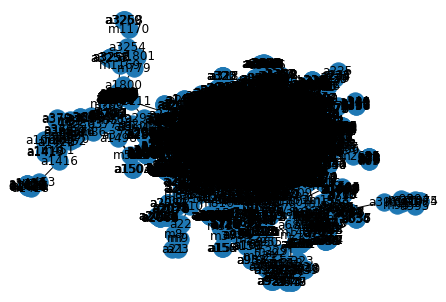

In [10]:
l, r = nx.bipartite.sets(A)
p = {}

p.update((node, (1, index)) for index, node in enumerate(l))
p.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, p=p, with_labels=True)
plt.show()

In [11]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('movies -->', len(movies))
print('actors -->', len(actors))

movies --> 1292
actors --> 3411


In [12]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Random Walks: {}".format(len(walks)))

Random Walks: 4703


In [13]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [14]:
model.wv.vectors.shape

(4703, 128)

In [15]:

node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [16]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    for i in range(len(node_ids)):
      if 'm' in node_targets[i]:
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
      else:
        actor_nodes.append(node_ids[i])  
        actor_embeddings.append(node_embeddings[i])


    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [17]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

In [18]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

In [19]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

In [20]:
def cost_1(graph,cluster):
  Gc = max(nx.connected_component_subgraphs(graph), key=len)
  connected=Gc.number_of_nodes()
  total_nodes=graph.number_of_nodes()
  value=((1/cluster)*(connected/total_nodes))
  return value  

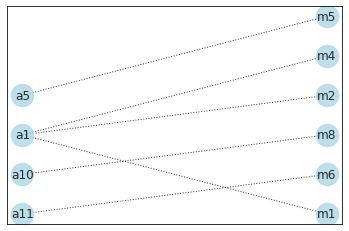

In [21]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [22]:
graded_cost1=cost_1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [23]:
def cost_2(graph,cluster):
  degree=graph.degree()
  degree_value=0 # to store sum of all  degree of actor nodes
  mov_nodes=0  #to store sum of all unique actor nodes
  for i in degree:
    if "a" in i[0]:
      degree_value=degree_value+i[1]
    else:
      mov_nodes=mov_nodes+1
  value=((1/cluster)*(degree_value/mov_nodes))
  return value     

In [24]:
graded_cost2=cost_2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [25]:
from sklearn.cluster import KMeans

In [26]:
cost_value={}
for clu in [3,5,10,50,200,300]:
  c1=0
  c2=0
  label=[]
  algo = KMeans(n_clusters=clu)
  algo.fit(actor_embeddings) # FITTING WITH KMEANS ALGO
  label=algo.labels_
  for i in range(clu):
     G1=nx.Graph()  # drawing graph for each cluster
     label_divi=[]
     k=[index for index, value in enumerate(label) if value == i]# accesing each cluster basesd on labels_
     label_divi=[ actor_nodes[l] for l in k]
     for node in label_divi:
       sub_graph1=nx.ego_graph(K,node)
       G1.add_nodes_from(sub_graph1.nodes) # adding nodes 
       G1.add_edges_from(sub_graph1.edges()) # adding edges 
     cst1=cost_1(G1,clu)
     c1=c1+cst1 # calculating cost functions
     cst2=cost_2(G1,clu) 
     c2=c2+cst2
  value=c1*c2 
  cost_value[clu]=value   


In [27]:
optimal_cluster_number = max(cost_value, key=cost_value.get) 
print("optimal cluster number = ",optimal_cluster_number)

optimal cluster number =  3


In [28]:
model= KMeans(n_clusters=optimal_cluster_number)
model.fit(actor_embeddings)
label=model.labels_

In [29]:
node_cluster={}
for i in range(optimal_cluster_number):
  k=[index for index, value in enumerate(label) if value == i]  
  label_divi=[ actor_nodes[l] for l in k]
  for node in label_divi:
    node_cluster[node]=i

In [30]:
node_cluster['a1435']

0

In [31]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

Text(0.5, 1.0, 'TSNE 2D visualization of actor embeddings')

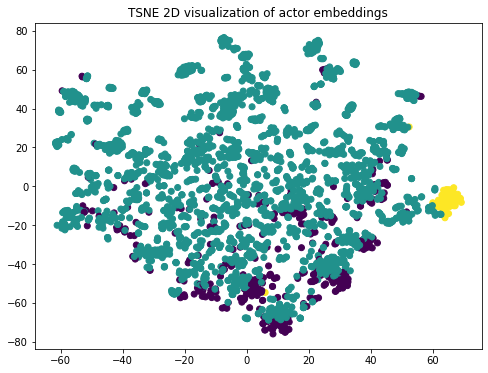

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6)) 
plt.scatter(actor_embeddings_2d[:,0], actor_embeddings_2d[:,1], c=model.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embeddings')

In [33]:
def cost_2(graph,cluster):
  degree=graph.degree()
  degree_value=0 # to store sum of all  degree of actor nodes
  act_nodes=0  #to store sum of all unique actor nodes
  for i in degree:
    if "m" in i[0]:
      degree_value=degree_value+i[1]
    else:
      act_nodes=act_nodes+1
  value=((1/cluster)*(degree_value/act_nodes))
  return value    

In [34]:
cost_value={}
for clu in [3,5,10,50,200,300]:
  c1=0
  c2=0
  label=[]
  algo = KMeans(n_clusters=clu)
  algo.fit(movie_embeddings)
  label=algo.labels_
  for i in range(clu):
     G1=nx.Graph() 
     label_divi=[]
     k=[index for index, value in enumerate(label) if value == i]
     label_divi=[ movie_nodes[l] for l in k]
     for node in label_divi:
       sub_graph1=nx.ego_graph(K,node)
       G1.add_nodes_from(sub_graph1.nodes) 
       G1.add_edges_from(sub_graph1.edges()) 
     cst1=cost_1(G1,clu)
     c1=c1+cst1 
     cst2=cost_2(G1,clu) 
     c2=c2+cst2
  value=c1*c2 
  cost_value[clu]=value   

In [35]:
optimal_cluster_number = max(cost_value, key=cost_value.get) 
print("Best Cluster Number ->",optimal_cluster_number)

Best Cluster Number -> 10


In [36]:
model= KMeans(n_clusters=optimal_cluster_number)
model.fit(movie_embeddings)
label=model.labels_

In [37]:
node_cluster={}
for i in range(optimal_cluster_number):
  k=[index for index, value in enumerate(label) if value == i]
  label_divi=[ movie_nodes[l] for l in k]
  for node in label_divi:
    node_cluster[node]=i

In [38]:
node_cluster['m858']

1

In [39]:


from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

Text(0.5, 1.0, 'TSNE 2D visualization of movie embeddings')

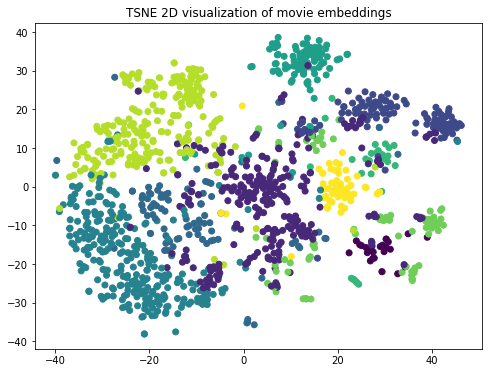

In [40]:

import matplotlib.pyplot as plt
# Visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(movie_embeddings_2d[:,0], movie_embeddings_2d[:,1], c=model.labels_.astype(float))
plt.title('TSNE 2D visualization of movie embeddings')